## Concept

* Type of forecasting -> aimed at removing/smoothing short term fluctuations (volatility)
* Esp useful with stock prices

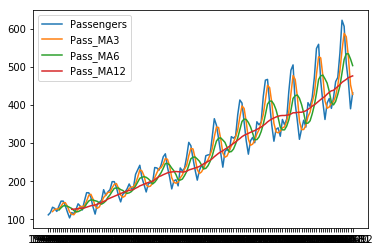

In [3]:
# airline data
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'data/airline.csv', index_col = 'Month')
df['Pass_MA3'] = df['Passengers'].rolling(window = 3).mean()
df['Pass_MA6'] = df['Passengers'].rolling(window = 6).mean()
df['Pass_MA12'] = df['Passengers'].rolling(window = 12).mean()

plt.plot(df['Passengers'])
plt.plot(df['Pass_MA3'])
plt.plot(df['Pass_MA6'])
plt.plot(df['Pass_MA12'])
plt.legend()
plt.show()

## Observations

* Lag : MA plot always lags by window size
* Noise : too small window -> less noise removal
* Avg : Avg cant capture high and low
* Weight : All given equal weighting in mean calc

## Cons

* Simple MA's are not worth even for baseline
* Need EMWA or higher order exp smoothig (Holt-Winters) for better way to weight recent observations

## Exponential Moving Average : Smoothing

* Not often used in forecasting, but complex members of its family can be used
* EWMA - weightage to more recent time points -> more relevant to future forecast

$$ y_t  = \frac{\sum w_i x_{t-i}}{\sum w_i}$$

* w -> weight, y -> output
* Weight parameters will be different over lags based on $\alpha$

$$ y_0 = x_0 $$


$$ y_t  = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + .. + (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + .. + (1 - \alpha)^t}$$

* $\alpha$ denotes decay rate, the weights exponentially decay 
* $\alpha$ value close to 1 indicates fast learning (that is, only the most recent values influence the forecasts), whereas a value close to 0 indicates slow learning (past observations have a large influence on forecasts).

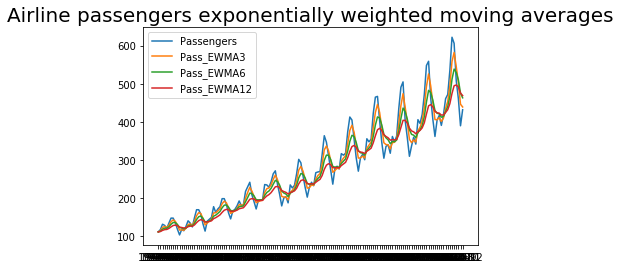

In [6]:
# Calculate
df['Pass_EWMA3'] = df['Passengers'].ewm(span=3, adjust=False).mean()
df['Pass_EWMA6'] = df['Passengers'].ewm(span=6, adjust=False).mean()
df['Pass_EWMA12'] = df['Passengers'].ewm(span=12, adjust=False).mean()

# Plot
plt.title('Airline passengers exponentially weighted moving averages', size=20)
plt.plot(df['Passengers'])
plt.plot(df['Pass_EWMA3'])
plt.plot(df['Pass_EWMA6'])
plt.plot(df['Pass_EWMA12'])
plt.legend();

## Observations

* They dont lag unlike normal moving averages
* Yet there arent good for forecasting - handles only level. 
* Need extra params to capture both trend and seasonality

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


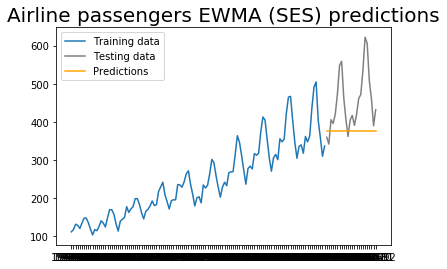

In [14]:
# understanding forecasting prob with SimpleExpSmoothing/EWMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Model parameters
span = 12 
alpha = 2 / (span + 1)

# read data
df = pd.read_csv(r'data/airline.csv', index_col = 'Month')

# Train/test split
df_train = df[:-24]
df_test = df[-24:]

# Train the model
model = SimpleExpSmoothing(df_train['Passengers'])
results = model.fit(smoothing_level=alpha, optimized=False)
df_test['predictions'] = results.forecast(steps=24)

# Plot
plt.title('Airline passengers EWMA (SES) predictions', size=20)
plt.plot(df_train['Passengers'], label='Training data')
plt.plot(df_test['Passengers'], color='gray', label='Testing data')
plt.plot(df_test['predictions'], color='orange', label='Predictions')
plt.legend();

## Observations
* One parameter (alpha) isn’t enough to capture trend and seasonality. It covers only level

## Double Exp Smoothening

* Support to trends 
* AKA Holt Winters Linear Trend model
* hyperparameters :
    * $\alpha$ for level : smoothing_level
    * $\beta$ for trend : smoothing_slope
    * Trend type : additive/multiplicative
    * Dampen type : additive/multiplicative
    * $\phi$ : Damping coeff (control size of trend over future)
    
    
* level : $l_t = \alpha y_t + (1 - \alpha) l_{t-1} $
* trend: $b_t = \beta (l_t - l_{t-1}) + (1 - \beta) b_{t-1} $
* forecast = $l_t + h * b_t $

* ExponentialSmoothing is a special class where we can fit Single, Double and Triple Smoothing

## Triple Exp Smoothening

* Support to trends, seasonal

![title](images\triple_exp_smooth.png)

* hyperparameters :
    * $\alpha$ for level : smoothing_level
    * $\beta$ for trend : smoothing_slope
    * $\gamma$ for seasonal : smoothing_seasonal
    * Trend type : additive/multiplicative
    * Dampen type : additive/multiplicative
    * $c_t$ : seasonal correction (control size of seasonal over future)

* ExponentialSmoothing is a special class where we can fit Single, Double and Triple Smoothing


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

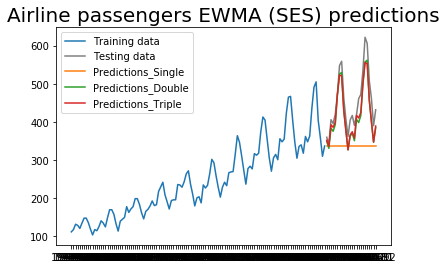

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# read data
df = pd.read_csv(r'data/airline.csv', index_col = 'Month')

# Train/test split
df_train = df[:-24]
df_test = df[-24:]

# Train the model
single_model = ExponentialSmoothing(df_train['Passengers']).fit()
df_test['predictions_single'] = single_model.forecast(steps=24)

double_model = ExponentialSmoothing(df_train['Passengers'], trend = 'mul', seasonal = 'mul', seasonal_periods=12)
double_model = double_model.fit(smoothing_slope = 0.1, smoothing_level = 0.3, damping_slope = 0.3)
df_test['predictions_double'] = double_model.forecast(steps=24)


triple_model = ExponentialSmoothing(df_train['Passengers'], trend = 'mul', seasonal = 'mul', seasonal_periods=12)
triple_model = triple_model.fit(smoothing_slope = 0.1, smoothing_level = 0.3, damping_slope = 0.3, smoothing_seasonal = 0.4)
df_test['predictions_triple'] = triple_model.forecast(steps=24)

# Plot
plt.title('Airline passengers EWMA (SES) predictions', size=20)
plt.plot(df_train['Passengers'], label='Training data')
plt.plot(df_test['Passengers'], color='gray', label='Testing data')
plt.plot(df_test['predictions_single'], label='Predictions_Single')
plt.plot(df_test['predictions_double'], label='Predictions_Double')
plt.plot(df_test['predictions_triple'], label='Predictions_Triple')
plt.legend();